Start with something simple, 2D, and only slightly nongaussian. The first will be a parabola-shaped gaussian-based pdf.

In [230]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [231]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

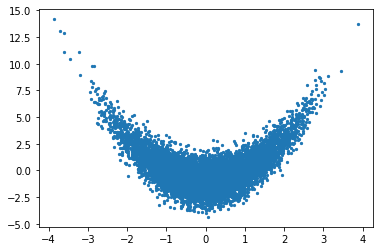

In [232]:
# Sample from the initial distribution
nsamples=10000
X_para = np.random.normal(0, 1, nsamples) 
Y_para = np.random.normal(X_para**2-1,1,nsamples)

plt.scatter(X_para,Y_para,s=5)

The example here is just going to be two 2d gaussians. Now to set up the MADE.


In [233]:
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[12,12], activation='sigmoid') # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution_para = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution_para.log_prob(x_)
model_para = tfk.Model(x_, log_prob_)

model_para.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata_para = np.stack([X_para, Y_para], axis=-1)
ydata_para = base_distribution.sample(nsamples)

batch_size = 100
model_para.fit(x=xdata_para,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=50,  # Usually `n // batch_size`.
          validation_split=0.3,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
50/50 [==============================] - 1s 6ms/step - loss: 3.5260 - val_loss: 3.3448
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3284 - val_loss: 3.3374
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3867 - val_loss: 3.3393
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3554 - val_loss: 3.3383
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3414 - val_loss: 3.3376
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3334 - val_loss: 3.3373
Epoch 7/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3780 - val_loss: 3.3383
Epoch 8/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3671 - val_loss: 3.3383
Epoch 9/100
50/50 [==============================] - 0s 2ms/step - loss: 3.3441 - val_loss: 3.3379
Epoch 10/100
50/50 [==============================] - 0s 3ms/step - loss: 3.3577 - val_loss: 3.3376
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 2.8936 - val_loss: 2.9036
Epoch 84/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8898 - val_loss: 2.9001
Epoch 85/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8886 - val_loss: 2.8974
Epoch 86/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8835 - val_loss: 2.8962
Epoch 87/100
50/50 [==============================] - 0s 2ms/step - loss: 2.9051 - val_loss: 2.8940
Epoch 88/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8824 - val_loss: 2.8922
Epoch 89/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8799 - val_loss: 2.8903
Epoch 90/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8874 - val_loss: 2.8881
Epoch 91/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8765 - val_loss: 2.8862
Epoch 92/100
50/50 [==============================] - 0s 2ms/step - loss: 2.8666 - val_loss: 2.8849
Epoch 93/100


Looks pretty Gausian! Now lets apply a fit, determine the full gaussian map, and plot some contours.

[[[-4.   -4.  ]
  [-4.   -3.99]
  [-4.   -3.98]
  ...
  [-4.    3.97]
  [-4.    3.98]
  [-4.    3.99]]

 [[-3.99 -4.  ]
  [-3.99 -3.99]
  [-3.99 -3.98]
  ...
  [-3.99  3.97]
  [-3.99  3.98]
  [-3.99  3.99]]

 [[-3.98 -4.  ]
  [-3.98 -3.99]
  [-3.98 -3.98]
  ...
  [-3.98  3.97]
  [-3.98  3.98]
  [-3.98  3.99]]

 ...

 [[ 3.97 -4.  ]
  [ 3.97 -3.99]
  [ 3.97 -3.98]
  ...
  [ 3.97  3.97]
  [ 3.97  3.98]
  [ 3.97  3.99]]

 [[ 3.98 -4.  ]
  [ 3.98 -3.99]
  [ 3.98 -3.98]
  ...
  [ 3.98  3.97]
  [ 3.98  3.98]
  [ 3.98  3.99]]

 [[ 3.99 -4.  ]
  [ 3.99 -3.99]
  [ 3.99 -3.98]
  ...
  [ 3.99  3.97]
  [ 3.99  3.98]
  [ 3.99  3.99]]]


(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0., 12.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [89.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
          0.],
        [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 31.,
         75.],
        [84., 18.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         11.],
        [ 0.,  0.,  4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
         85.],
        [ 0.,  0.,  0

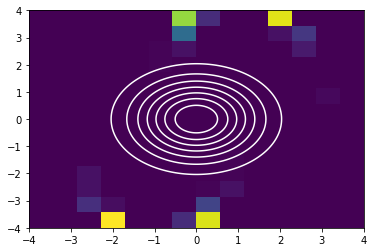

In [234]:
from scipy.stats import multivariate_normal

# This is just a fixed gaussian. I first want to see how this lines up with the samples

dist_x, dist_y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((dist_x, dist_y))

print(pos)
rv = multivariate_normal([0., 0.], [[1.0, 0.], [0., 1.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contour(dist_x, dist_y, rv.pdf(pos),colors='w')
ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

In [235]:
'''
Here what I am doing is finding values to perform the fit. I can start with using the previous histgram and using
a midpoint approximation.
'''

#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[0])
results = np.stack(ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[0])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[1])
#print(ax2.hist2d(x,y,bins=[np.linspace(-4,4,10),np.linspace(-4,4,10)])[2])
binx=[]
biny=[]
edge_x = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[1]
edge_y = ax2.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])[2]

for i in range(len(edge_x)-1):
    binx.append((edge_x[i+1]-edge_x[i])/2 + edge_x[i])
for i in range(len(edge_y)-1):
    biny.append((edge_y[i+1]-edge_y[i])/2 + edge_y[i])

bins=[]
z=[]
#bins.append(binx)
#bins.append(biny)
xvals = []
yvals = []

for i in range(len(binx)-1):
    for j in range(len(biny)-1):
        xvals.append(binx[i])
        yvals.append(biny[j])
        z.append(results[i][j])
        
#print(xvals)
#print(yvals)
#print(z)

In [236]:
# Instead of relying on a perfect gaussian, instead I will perform a fit so that We can see where the loss 
# comes from. Ideally will have mean=(0,0) and cov=diag(1,1)

# Thanks https://stackoverflow.com/questions/52148141/2d-gaussian-fit-using-lmfit 
# since it has been so long since I used lmfit

from lmfit import Parameters, minimize, report_fit

def gaussian2D(x, y, cen_x, cen_y, sig_x, sig_y):
    return np.exp(-(((cen_x-x)/sig_x)**2 + ((cen_y-y)/sig_y)**2)/2.0)

def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma_x = p["sigma_x"].value
    sigma_y = p["sigma_y"].value
    return (z - height*gaussian2D(x,y, cen_x, cen_y, sigma_x, sigma_y))

initial = Parameters()
initial.add("height",value=1.)
initial.add("centroid_x",value=0.)
initial.add("centroid_y",value=0.)
initial.add("sigma_x",value=1.)
initial.add("sigma_y",value=1.)

fit = minimize(residuals, initial, args=(xvals,yvals, z))
print(report_fit(fit))

# need to implement a covariance term in the model

ModuleNotFoundError: No module named 'lmfit'

In [237]:
# Now plot the fit over the histogram
Xvals = np.linspace(-4,4,100)
Yvals = np.linspace(-4,4,100)
Xvals,Yvals = np.meshgrid(Xvals, Yvals)

xo = fit.params["centroid_x"].value
yo = fit.params["centroid_y"].value
sx = fit.params["sigma_x"].value
sy = fit.params["sigma_y"].value

Z=gaussian2D(Xvals,Yvals,xo,yo,sx,sy)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])

NameError: name 'fit' is not defined

Now lets evaluate the NN fit. First I will take the sampled data and map it back to the non-gaussian parameter space. Then I will map the contours of the gaussian fit to the non-gaussian parameter space.

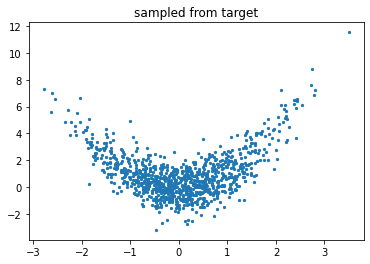

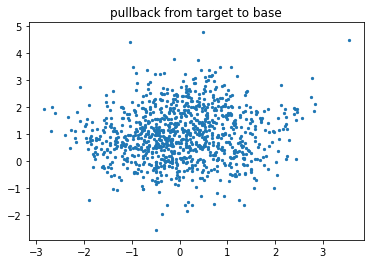

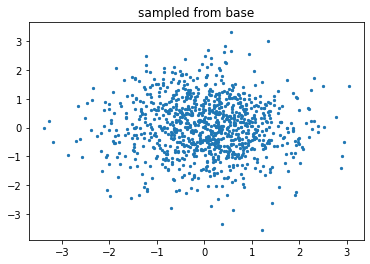

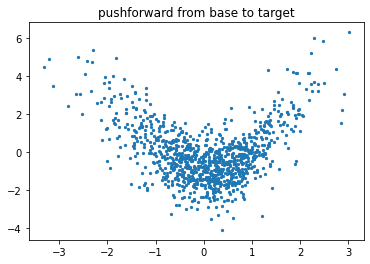

In [238]:
'''
1. Sample from original distribution
2. pull back from the original to the gaussian using the NN bijector inverse
3. sample from gaussian
4. push forward from the gaussian to the original using NN bijector
'''

# resample from target distribution
X = np.random.normal(0, 1, 1000) 
Y = np.random.normal(X**2,1,1000)

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution_para.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution_para.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

Cool!

In [239]:
# Evaluate fit on gaussian, pushforward to find contours

x_points , y_points = np.mgrid[-3:3:.05, -3:3:.05]
xy_points = np.stack((x_points, y_points),axis=-1)
print(x_points)
print(y_points)
z_vals=gaussian2D(x_points,y_points,xo,yo,sx,sy)
x_pos=[]
y_pos=[]

#for i in range(len(x_points)):
#    for j in range(len(y_points)):
#        pos=xy_points[i][j]
#        z_vals.append(gaussian2D(pos[0],pos[1],xo,yo,sx,sy))
#        append to list to use when evaluating NN model
#        x_pos.append(pos[0])
#        y_pos.append(pos[1])

# pushforward points to target distribution
contour_pushforward = target_distribution.bijector.forward(tf.cast(xy_points,tf.float32))

contour_x = contour_pushforward[...,0].numpy()
contour_y = contour_pushforward[...,1].numpy()
    
#np.stack((contour_x,contour_y),axis=-1)
#print(contour_x)
#print(contour_y)

[[-3.   -3.   -3.   ... -3.   -3.   -3.  ]
 [-2.95 -2.95 -2.95 ... -2.95 -2.95 -2.95]
 [-2.9  -2.9  -2.9  ... -2.9  -2.9  -2.9 ]
 ...
 [ 2.85  2.85  2.85 ...  2.85  2.85  2.85]
 [ 2.9   2.9   2.9  ...  2.9   2.9   2.9 ]
 [ 2.95  2.95  2.95 ...  2.95  2.95  2.95]]
[[-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 ...
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]
 [-3.   -2.95 -2.9  ...  2.85  2.9   2.95]]


NameError: name 'gaussian2D' is not defined

NameError: name 'contour_x' is not defined

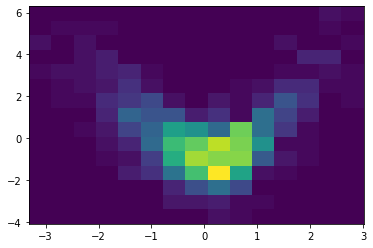

In [240]:
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')

In the plot above, what I did was take the gaussian contours and map them under the bijector from the neural net. We can see that this matches well with the initial generated distribution. Lastly, lets try to estimate the mass above 0. My strategy is as follows:

1. Using the contours found above, determine the contour that passes through the origin.
2. Sample points from the normalized space and map them to the 

NameError: name 'contour_x' is not defined

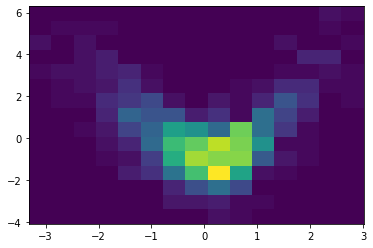

In [241]:
## Add a visualization for the origin

fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.contour(contour_x,contour_y,z_vals,colors='w')
ax.plot([0,0],[-4,10],color='k',linestyle='dashed')
ax.plot([-5,5],[0,0],color='k',linestyle='dashed')
ax.scatter(0,0,color='k')

tf.Tensor([ 0.58948326 -0.04328983], shape=(2,), dtype=float32)


NameError: name 'Z' is not defined

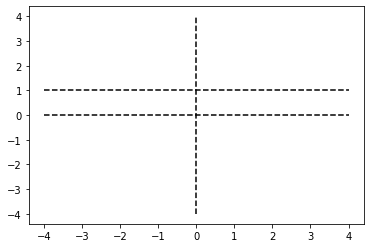

In [242]:
# Visualize what happens to the origin in the original parameter space under the pullback

origin_pullback = target_distribution.bijector.inverse([0.,0.])
print(origin_pullback)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot([0,0],[-4,4],color='k',linestyle='dashed')
ax3.plot([-4,4],[0,0],color='k',linestyle='dashed')
ax3.plot([-4,4],[1,1],color='k',linestyle='dashed')
ax3.contour(Xvals, Yvals, Z,colors='w')
ax3.hist2d(x,y,bins=[np.linspace(-4,4,15),np.linspace(-4,4,15)])
ox_pb = origin_pullback.numpy()[0]
oy_pb = origin_pullback.numpy()[1]
ax3.scatter(ox_pb,oy_pb,color='k')

In [243]:
# Compare pdf values. Use the prob from original distribution to compute MC integral

#po_pb=gaussian2D(ox_pb,oy_pb,xo,yo,sx,sy)
#print(po_pb)

prob = target_distribution_para.prob([0.,0.])
print(prob)

tf.Tensor(0.09631956, shape=(), dtype=float32)


120
120


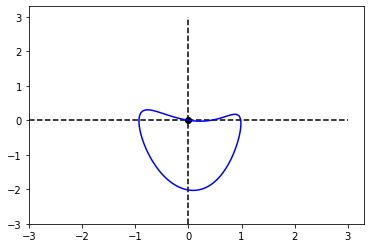

In [244]:
# Plot contour

z_vals = target_distribution_para.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-3,3],color='k',linestyle='dashed')
ax.plot([-3,3],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

To compute the integral, I can sample from the gaussian and use monte carlo integration. I can test whether a point lies in the 0-contour region of the domain. I don't know how to do error analysis for monte carlo integration, so I cannot implement anything in that regard right now.

In [245]:
# integrate

n_points = 10000
n_pass = 0

_s = target_distribution_para.sample(n_points)
_v = target_distribution_para.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print(n_pass/n_points)

0.4072


Now lets try another simple example: two 2d gaussians separated in space. This time the distribution is multimodal, so the contour passing through the origin may be more complicated. I have tried this a few times, and the main problem it has is that it just tries to shift the two gaussians, so the inverse map does nothing more than stretch along some axis. You can see the loss function is much higher at the end of the training than for the above case. Bijectors must be smooth functions, so there is a restriction about how the shift can occur.

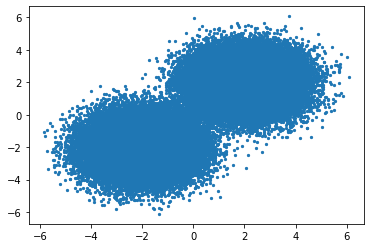

In [246]:
# Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [247]:
## Create the initial distribution
nsamples=100000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

#plt.scatter(X,Y,s=5)

## NN setup
# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

#use multiple bijectors, should hopefully get a better result
bijectors=[]
n_bijectors = 3
for i in range(n_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
    
target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.Chain(bijectors))#tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 1000
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=80,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
80/80 [==============================] - 1s 6ms/step - loss: 2510.2239 - val_loss: 6.7889
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 18.5001 - val_loss: 6.7659
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 16.6551 - val_loss: 6.7405
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 14.9013 - val_loss: 6.7137
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 13.3544 - val_loss: 6.6870
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 12.0404 - val_loss: 6.6609
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 10.9421 - val_loss: 6.6358
Epoch 8/100
80/80 [==============================] - 0s 4ms/step - loss: 10.0305 - val_loss: 6.6115
Epoch 9/100
80/80 [==============================] - 0s 4ms/step - loss: 9.2730 - val_loss: 6.5882
Epoch 10/100
80/80 [==============================] - 0s 4ms/step - loss: 8.6420 - val_loss: 6.5659

Epoch 83/100
80/80 [==============================] - 0s 5ms/step - loss: 4.0388 - val_loss: 4.7304
Epoch 84/100
80/80 [==============================] - 0s 5ms/step - loss: 4.0259 - val_loss: 4.7005
Epoch 85/100
80/80 [==============================] - 0s 4ms/step - loss: 4.0140 - val_loss: 4.6722
Epoch 86/100
80/80 [==============================] - 0s 5ms/step - loss: 4.0031 - val_loss: 4.6456
Epoch 87/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9932 - val_loss: 4.6207
Epoch 88/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9843 - val_loss: 4.5973
Epoch 89/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9763 - val_loss: 4.5758
Epoch 90/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9692 - val_loss: 4.5557
Epoch 91/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9628 - val_loss: 4.5372
Epoch 92/100
80/80 [==============================] - 0s 4ms/step - loss: 3.9571 - val_loss: 4.5198


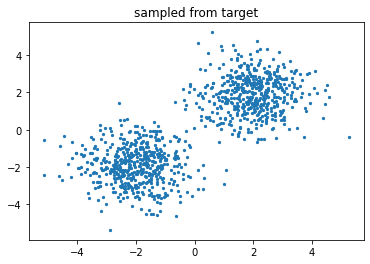

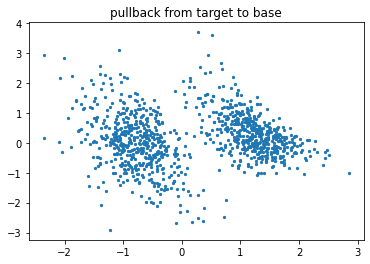

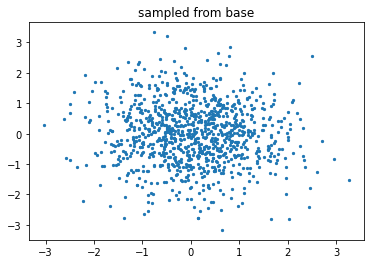

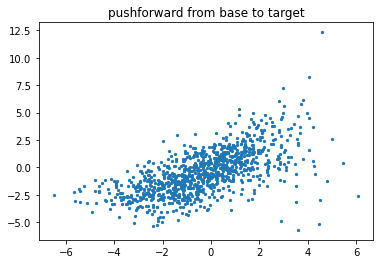

In [248]:
### Check bijector
# resample from target distribution
nsamples=1000
X1 = np.random.normal(-2, 1, int(nsamples/2))
X2 = np.random.normal(2, 1, int(nsamples/2)) 
Y1 = np.random.normal(-2,1,int(nsamples/2))
Y2 = np.random.normal(2,1,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.061172947, shape=(), dtype=float32)
2000
2000
integral =  0.0052


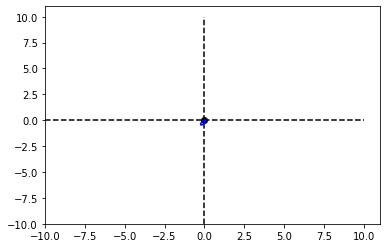

In [250]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

One more example. Lets instead combine the two previous examples!

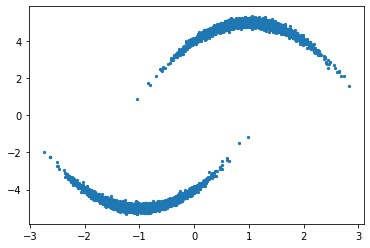

In [254]:
# Create the initial distribution

nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

plt.scatter(X,Y,s=5)

In [257]:
## NN setup

# Set up bijector MADE
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[8,8], activation=tf.math.asinh) # not sure what hidden units are 

# Define the target distribution
base_distribution = tfd.Normal(loc=0., scale=1.)

target_distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(base_distribution, sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(made)) 

# Construct model.
x_ = tfk.Input(shape=(2,), dtype=tf.float32)
log_prob_ = target_distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob) 

# adam is a 'stochastic' gradient descent algorithm
# Don't quite understand the format of the loss function here. 

# now perform the fit
xdata = np.stack([X, Y], axis=-1)
ydata = base_distribution.sample(nsamples)
#print(data)
#plt.scatter(X,Y,s=5)

batch_size = 80
model.fit(x=xdata,
          y=np.zeros((int(nsamples), 2), dtype=np.float32),
          batch_size=batch_size,
          epochs=100,
          steps_per_epoch=100,  # Usually `n // batch_size`.
          validation_split=0.2,
          shuffle=True,
          verbose=True) #, ydata


Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 9.2813 - val_loss: 6.3753
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 4.9358 - val_loss: 4.6906
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 4.3404 - val_loss: 4.4970
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 4.1953 - val_loss: 4.4535
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 4.0494 - val_loss: 4.3924
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8175 - val_loss: 4.3363
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 3.5743 - val_loss: 4.2388
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 3.4906 - val_loss: 4.0913
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 3.4487 - val_loss: 3.9706
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 3.4153 - val_lo

100/100 [==============================] - 0s 2ms/step - loss: 1.8259 - val_loss: 2.2617
Epoch 82/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8322 - val_loss: 2.1947
Epoch 83/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8365 - val_loss: 2.2296
Epoch 84/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8407 - val_loss: 2.2158
Epoch 85/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8416 - val_loss: 2.2167
Epoch 86/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8342 - val_loss: 2.2618
Epoch 87/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8759 - val_loss: 2.2126
Epoch 88/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8321 - val_loss: 2.1749
Epoch 89/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8336 - val_loss: 2.1649
Epoch 90/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8337 - val_loss: 

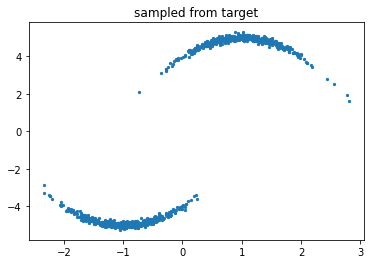

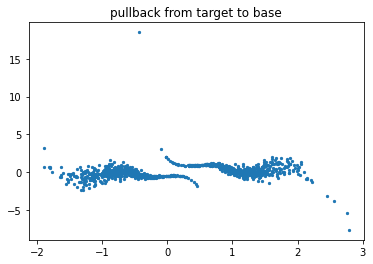

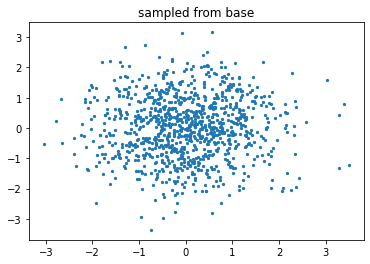

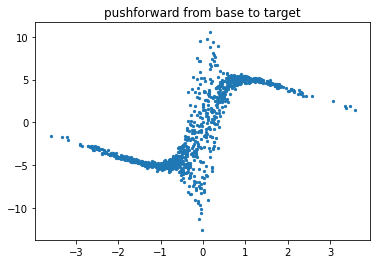

In [258]:
### Check bijector
# resample from target distribution
nsamples=1000

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))


X = np.concatenate([X1,X2])
Y = np.concatenate([Y1,Y2])

test_data=np.stack((X,Y),axis=-1)

# resample from base distribution
s=1000
samples = base_distribution.sample((s,2))

x = samples[...,0].numpy()
y = samples[...,1].numpy()

# pull back target dist to normal base dist 
pullback = target_distribution.bijector.inverse(tf.cast(test_data,tf.float32))

pb_x = pullback[...,0].numpy()
pb_y = pullback[...,1].numpy()

# push forward normal dist. back to target
pushforward = target_distribution.bijector.forward(samples)

pf_x = pushforward[...,0].numpy()
pf_y = pushforward[...,1].numpy()

# plot
fig_original = plt.figure()
fig_transformed = plt.figure()
fig_sampled = plt.figure()
fig_inverse = plt.figure()
    
ax1 = fig_original.add_subplot(111)
ax2 = fig_transformed.add_subplot(111)
ax3 = fig_sampled.add_subplot(111)
ax4 = fig_inverse.add_subplot(111)

ax1.set_title("sampled from target")
ax2.set_title("pullback from target to base")
ax3.set_title("sampled from base")
ax4.set_title("pushforward from base to target")

ax1.scatter(X,Y,s=5)
ax2.scatter(pb_x,pb_y,s=5)
ax3.scatter(x,y,s=5)
ax4.scatter(pf_x,pf_y,s=5)

tf.Tensor(0.025370358, shape=(), dtype=float32)
2000
2000
integral =  0.8362


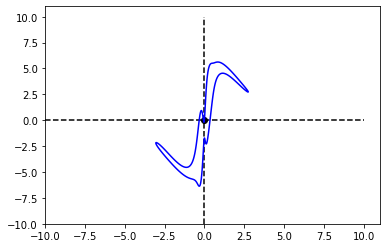

In [259]:
prob = target_distribution.prob([0.,0.])
print(prob)

x_points , y_points = np.mgrid[-10:10:.01, -10:10:.01]
xy_points = np.stack((x_points, y_points),axis=-1)

z_vals = target_distribution.prob(xy_points)
print(len(xy_points))
print(len(z_vals))
x_vals = xy_points
fig_contours = plt.figure()
ax = fig_contours.add_subplot(111)
#ax.hist2d(pf_x,pf_y,bins=[15,15])
ax.plot([0,0],[-10,10],color='k',linestyle='dashed')
ax.plot([-10,10],[0,0],color='k',linestyle='dashed')
ax.contour(x_points , y_points,z_vals,colors='b',levels=[prob])
ax.scatter(0,0,color='k')

n_points = 10000
n_pass = 0

_s = target_distribution.sample(n_points)
_v = target_distribution.prob(_s)
for val in _v:
    if val>prob:
        n_pass+=1
        
print("integral = ",n_pass/n_points)

I Want to explore something here. Composing bijectors successively approximating normal distriutions.

run: 1
run: 2
run: 3
run: 4
run: 5


"\n#print(bijectors)\nprint(dists)\ndata = bijectors[1].forward(dists[1])\nx = data[...,0]\ny = data[...,1]\nplot(x,y,'final')\n"

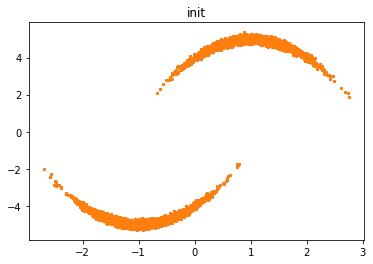

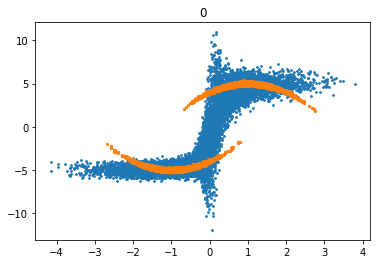

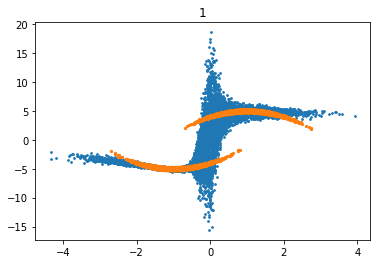

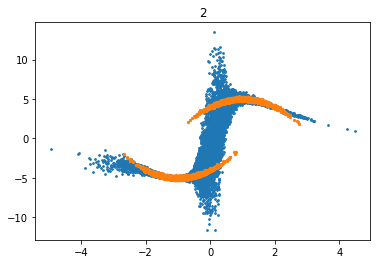

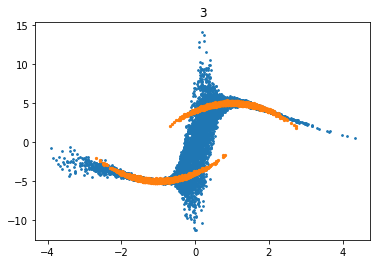

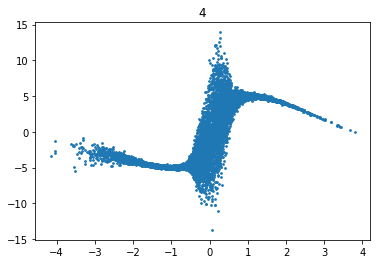

In [260]:
def sample(n,dist):
    p = dist.sample(n)
    px = p[...,0]
    py = p[...,1]
    return(px,py)
    
def train(base,X,Y):
    nsamples=10000
    ## NN setup
    # Set up bijector MADE
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[4,4], activation=tf.math.asinh) # not sure what hidden units are 

    target_distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(base),
        bijector=tfb.MaskedAutoregressiveFlow(made)) 

    # Construct model.
    x_ = tfk.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = target_distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  loss=lambda _, log_prob: -log_prob) 

    # adam is a 'stochastic' gradient descent algorithm
    # Don't quite understand the format of the loss function here. 

    # now perform the fit
    xdata = np.stack([X, Y], axis=-1)
    ydata = base.sample(nsamples)
    #print(data)
    plt.scatter(X,Y,s=5)

    batch_size = 100
    model.fit(x=xdata,
              y=np.zeros((int(nsamples), 2), dtype=np.float32),
              batch_size=batch_size,
              epochs=100,
              steps_per_epoch=50,  # Usually `n // batch_size`.
              validation_split=0.2,
              shuffle=True,
              verbose=True) #, ydata
    
    return(target_distribution)
    
def plot(x,y,title):
    plt.figure()
    plt.title(title)
    plt.scatter(x,y,s=3)
    
trained_dist = tfd.MultivariateNormalDiag(loc=[0.,0.], scale_diag=[1.,1.])

#init samples
nsamples=10000
center = 1
stdevx = 0.5
stdevy = 0.1
shifty = 5

X1 = np.random.normal(-1*center, stdevx, int(nsamples/2))
X2 = np.random.normal(center, stdevx, int(nsamples/2)) 
Y1 = np.random.normal((X1+center)**2-shifty, stdevy, int(nsamples/2))
Y2 = np.random.normal(-(X2-center)**2+shifty,stdevy,int(nsamples/2))

x = np.concatenate([X1,X2])
y = np.concatenate([Y1,Y2])

plot(x,y,"init")

bijectors=[]
#dists=[]

n_runs = 5

for i in range(n_runs):
    #print(trained_dist)
    print('=====')
    print('run: '+str(i+1))
    print('=====')
    trained_dist = train(trained_dist,x,y)
    bijectors.append(trained_dist.bijector)
    sx,sy = sample(n_samples,trained_dist)
    #dists.append(samples)
    plot(sx,sy,str(i))
 
'''
#print(bijectors)
print(dists)
data = bijectors[1].forward(dists[1])
x = data[...,0]
y = data[...,1]
plot(x,y,'final')
'''